## Structure prediction of copper phosphides

### Abstract

Through computational structure searching, we identify and characterize structures within the Cu-P family using density-functional theory (DFT) calculations.  This study highlights a novel $Fm\bar{3}m$ phase of Cu$_\mathrm{2}$P, which has a theoretical gravimetric capacity of 508 mAh/g, higher than the known conversion anode Cu$_3$P. By thermally populating the modes from DFT phonon calculations, we predict $Fm\bar{3}m$ Cu$_2$P to be stable at room temperature. We present a convex hull of several stable Cu-P structures, which suggests that Cu$_3$P is also stabilized by increased temperature, and confirms a metastable phase of Cu$_{3-x}$P. Band structure and density of states calculations show that Cu$_2$P is a semimetal with a similar structural relationship to both Ir$_2$P and Rh$_2$P. These first-principles predictions of the stable Cu$_2$P phase suggest that it is experimentally synthesizable, and its predicted properties as a high capacity conversion anode for lithium-ion batteries suggest further research into this phase.


### Imports

In [1]:
from matador.config.config import set_settings
set_settings(
    {
        'plotting': {
            'element_colours': './config/vesta_elements.ini',
            'default_style': ['matador', './config/CuP.mplstyle']
        }
    }
)

In [2]:
import warnings
warnings.filterwarnings('ignore')

import tqdm
import glob
import pickle

import numpy as np    
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import set_matplotlib_formats
# ME: revert to png here for now to save space
set_matplotlib_formats('png')

from matador.query import DBQuery
from matador.hull import QueryConvexHull
from matador.hull import EnsembleHull
from matador.scrapers import castep2dict, res2dict
from matador.utils.cursor_utils import filter_unique_structures
from matador.utils.cell_utils import standardize_doc_cell, get_spacegroup_spg


## Results

### Structure prediction step

In [3]:
# load AIRSS structures obtained from searching (old)
cursor, failures = res2dict('/u/fs1/afh41/proj/Cu+P/hull-CuP500501-afh41-LiCuP-polish1/*.res', db=True)
if failures:
    print(failures)

for doc in cursor:
    src = doc['source'][0].split('/')[-1]
    if src == 'Cu3P-OQMD_2966-CollCode15056.res':
        print(src)

Cu3P-OQMD_2966-CollCode15056.res


In [4]:
# do some pruning: reevaluate symmetries and reduce cells
cursor = [standardize_doc_cell(doc, ) for doc in cursor]
for doc in cursor:
    doc['space_group'] = get_spacegroup_spg(doc, symprec=0.1)
for doc in cursor:
    src = doc['source'][0].split('/')[-1]
    if src == 'Cu3P-OQMD_2966-CollCode15056.res':
        print(src)

Cu3P-OQMD_2966-CollCode15056.res


In [5]:
# filter them for uniqueness to retain 44 structures
filtering = True
if filtering:
    polished_cursor = filter_unique_structures(cursor, quiet=True)
else:
    polished_cursor = cursor

Calculating fingerprints...
Assessing similarities...
Skipping 12 structures out of 241
Running 229 jobs on at most 6 processes, set by core count.
0 0 / 229   97%
1 1
2 2
3 3
4 4
5 5
6 6
7 7
8 8
9 9
10 10
11 11
12 12
13 13
14 14
15 15
16 16
17 17
18 18
19 19
20 20
21 21
22 22
23 23
24 24
25 25
26 26
27 27
28 28
29 29
30 30
31 31
32 32
33 33
34 34
35 35
36 36
37 37
38 38
39 39
40 40
41 41
42 42
43 43
44 44
45 45
46 46
47 47
48 48
49 49
50 50
51 51
53 52
54 53
55 54
56 55
57 56
59 57
60 58
61 59
62 60
63 61
64 62
65 63
66 64
67 65
68 66
69 67
70 68
71 69
72 70
73 71
74 72
75 73
76 74
77 75
78 76
79 77
80 78
81 79
82 80
83 81
84 82
85 83
86 84
87 85
89 86
90 87
91 88
92 89
93 90
94 91
95 92
96 93
97 94
98 95
99 96
100 97
101 98
102 99
103 100
104 101
105 102
106 103
107 104
108 105
109 106
110 107
111 108
112 109
113 110
114 111
116 112
117 113
118 114
119 115
120 116
121 117
122 118
123 119
124 120
125 121
126 122
127 123
128 124
129 125
130 126
131 127
132 128
133 129
134 130
135 131
1

In [6]:
polished_hull = QueryConvexHull(
    cursor=polished_cursor, 
    species=['Cu', 'P'], 
    no_plot=True
)

6 structures found within 0.0 eV of the hull, including chemical potentials.
───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
                 Source                  !?!  Pressure  Volume/fu  Hull dist.   Space group     Formula      # fu   Prov.  
                                               (GPa)     (Ang^3)   (meV/atom)  
───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
* Cu-OQMD_592441-CollCode43493_0[..]             -0.00       11.9          0.0    Fm-3m          Cu          1      ICSD  
* Cu2P-swap-PRh2-OQMD_7002-CollC[..]              0.01       41.6          0.0    Fm-3m         Cu2P         1     SWAPS  
* CuP2-OQMD_6538-CollCode35282_3[..]              0.05       48.9          0.0   P2_1/c         CuP2         4      ICSD  
* Cu2P7-OQMD_6537-CollCode35281_0                -0.08      163.3          0.0    C2/m          Cu2P7 

Using config from /u/fs1/afh41/.matadorrc


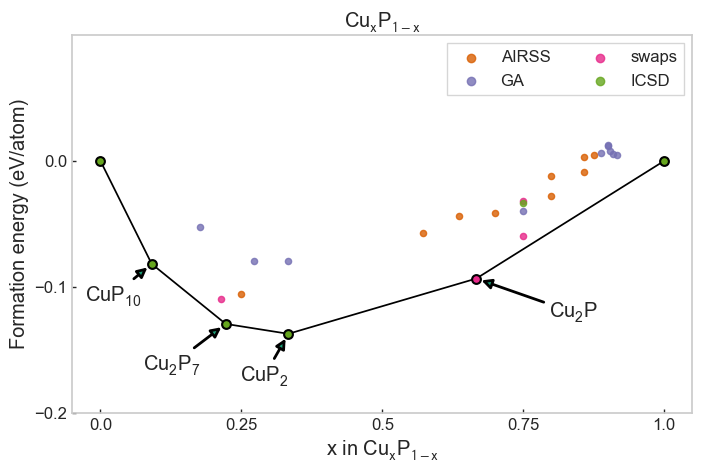

In [24]:
from matador.plotting import plot_2d_hull
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(8, 5))
ax = plot_2d_hull(
    polished_hull,
    ax=ax,
    label_cutoff=8e-3, 
    colour_by_source=True,
    hull_cutoff=0.01,
    plot_hull_points=False,
    show=False,
    alpha=0.8, 
    label_offset=(1.15, 0.02),
    eform_limits=(-0.2, 0.1),
    sources=['AIRSS', 'GA', 'SWAPS', 'ICSD','OQMD'],
    source_labels=['AIRSS', 'GA','swaps','ICSD','OQMD']
)
ax.set_yticks([-0.2, -0.1, 0])
ax.tick_params(direction='in')
#plt.show()
plt.savefig('CuP-convex-hull.png',bbox_inches='tight',transparent=True)

In [8]:
from matador.utils.cursor_utils import display_results
# Print a table of all the structures with negative formation energy which are also within 50 meV of hull
# currently "summary" means it takes the best structure at each stoich
table_args = {'hull': True, 'summary': False,'use_source': True}

table_cursor = [doc for doc in polished_hull.cursor if doc['hull_distance'] <= 0.1 and doc['formation_enthalpy'] <= 0]
display_results(table_cursor, **table_args)
latex_table = display_results(table_cursor, latex=True, return_str=True, **table_args)
# replace caps "SWAPS" with "swaps"
latex_table = latex_table.replace("SWAPS", "swaps")
with open('CuP_table.tex', 'w') as f:
    f.write(latex_table)

───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
                 Source                  !?!  Pressure  Volume/fu  Hull dist.   Space group     Formula      # fu   Prov.  
                                               (GPa)     (Ang^3)   (meV/atom)  
───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
* Cu-OQMD_592441-CollCode43493_0[..]             -0.00       11.9          0.0    Fm-3m          Cu          1      ICSD  
  CuP_ratios-anbf0moptimised                     -0.02       44.7         31.3   I4/mmm         Cu6P         2     AIRSS  
  CuP_ratios-kzw2kyoptimised                     -0.05       65.6         28.2   P4/nmm         Cu4P         2     AIRSS  
  CuP_ratios-ty38s2optimised                      0.02       65.5         43.9    Cmmm          Cu4P         1     AIRSS  
  Cu3P-swap-AsCu3-OQMD_11878-Col[..]             -0.04  

### Li-Cu-P ternary

In [9]:
cursor, failures = res2dict('/u/fs1/afh41/voltage-LiCuP-700eV/*.res', db=True)

if failures:
    print(failures)

In [10]:
# This is the ternary hull used to create the voltage profiles with a plane wave cutoff of 700 eV.
# It has ommitted the disputed Cu-Li phases and the high P content Cu-P phases to identify 
# specifically the Cu3P and Cu2P voltage profiles

ternary_hull = QueryConvexHull(cursor=cursor,
        expt='/u/fs1/afh41/voltage-LiCuP-afh41-LiCuP-noCu2P/Cu3P-expt-voltage-bichat2004electrochemicalC8.csv',
        expt_label='Cu$_3$P experimental Bichat et al (2004)',
        no_plot=True,
        capmap=True,
        pathways=True,
        subcmd='voltage', 
        elements=['Li', 'Cu', 'P'])

11 structures found within 0.0 eV of the hull, including chemical potentials.
───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
                 Source                  !?!  Pressure  Volume/fu  Hull dist.   Space group     Formula      # fu   Prov.  
                                               (GPa)     (Ang^3)   (meV/atom)  
───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
* Cu-OQMD_592441-CollCode43493                    0.03       11.9          0.0    Fm-3m          Cu          1      ICSD  
* Cu2P-swap-PRh2-OQMD_7002-CollC[..]              0.00       41.6          0.0    Immm          Cu2P         1     SWAPS  
* Cu2LiP2-OQMD_2275-CollCode2734                  0.01       72.5          0.0   I4/mmm        Cu2LiP2       1      ICSD  
* Cu4Li5P6-OQMD_33279-CollCode2735               -0.08      216.1          0.0    Immm        Cu4Li5P

In [11]:
# remove Cu2P from the plot and calculate the convex hull without Cu2P
noCu2Pcursor = [doc for doc in cursor if (doc['stoichiometry'] != [['Cu',2],['P',1]])]
noCu2Pcursor = [doc for doc in noCu2Pcursor if doc['source'][0].split('/')[-1] != 'Cu3P-OQMD_2966-CollCode15056-OTF.res']

hullnoCu2P = QueryConvexHull(cursor=noCu2Pcursor,
        no_plot=True,
        subcmd='voltage', 
        elements=[ 'Li','Cu', 'P'])

Something fishy with height above plane, returning 0...
0.0 0.0 0.0
[ 0.05904794  0.         -0.        ]
Something fishy with height above plane, returning 0...
0.0 0.75 -0.05904793750003279
[ 0.05904794  0.         -0.        ]
11 structures found within 0.0 eV of the hull, including chemical potentials.
───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
                 Source                  !?!  Pressure  Volume/fu  Hull dist.   Space group     Formula      # fu   Prov.  
                                               (GPa)     (Ang^3)   (meV/atom)  
───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
* Cu-OQMD_592441-CollCode43493                    0.03       11.9          0.0    Fm-3m          Cu          1      ICSD  
* Cu3P-swap-AsCu3-OQMD_11878-Col[..]             -0.08       52.5          0.0     Cc           Cu3P         8     SW

In [12]:
# remove I43d Cu3P from cursor and plot with the ICSD P63cm Cu3P
noI43dCu3P = [doc for doc in cursor if (doc['stoichiometry'] != [['Cu',2],['P',1]])]
noI43dCu3P = [doc for doc in noI43dCu3P if doc['source'][0].split('/')[-1] != 'Cu3P-swap-AsCu3-OQMD_11878-CollCode64715.res']
        
hullnoI43dCu3P = QueryConvexHull(cursor=noI43dCu3P,
        no_plot=True,
        subcmd='voltage', 
        elements=['Li', 'Cu', 'P'])

Something fishy with height above plane, returning 0...
0.0 0.0 0.0
[ 0.03337606  0.         -0.        ]
Something fishy with height above plane, returning 0...
0.0 0.75 -0.0333760624998618
[ 0.03337606  0.         -0.        ]
11 structures found within 0.0 eV of the hull, including chemical potentials.
───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
                 Source                  !?!  Pressure  Volume/fu  Hull dist.   Space group     Formula      # fu   Prov.  
                                               (GPa)     (Ang^3)   (meV/atom)  
───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
* Cu-OQMD_592441-CollCode43493                    0.03       11.9          0.0    Fm-3m          Cu          1      ICSD  
* Cu3P-OQMD_2966-CollCode15056-OTF               -0.07       50.7          0.0   P6_3cm         Cu3P         6     SWA

In [13]:
from matador.plotting import plot_voltage_curve
# revert to matador colourscheme
set_settings({'plotting': {'default_style': 'matador'}})

Using config from /u/fs1/afh41/.matadorrc
Using config from /u/fs1/afh41/.matadorrc
Using config from /u/fs1/afh41/.matadorrc


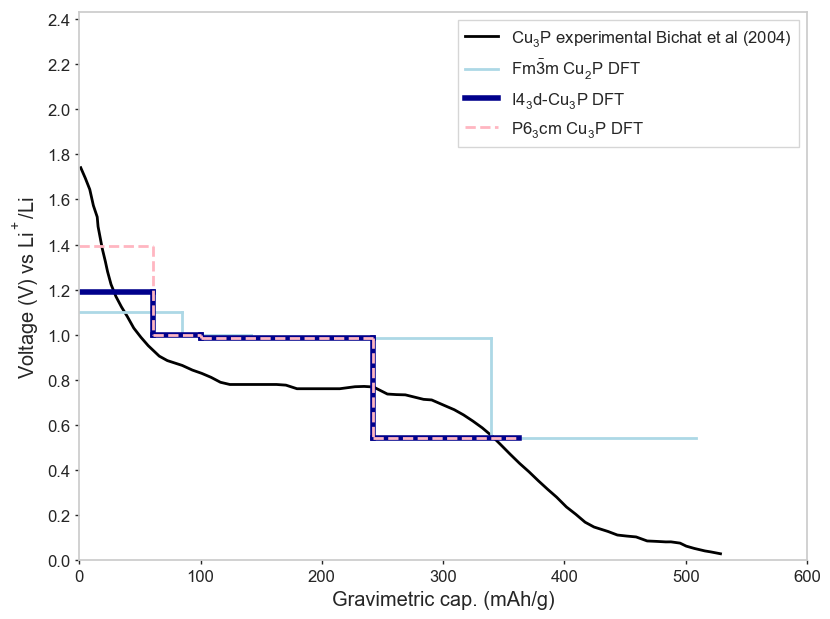

In [14]:
fig, ax = plt.subplots()
ax = plot_voltage_curve(ternary_hull, 
                        ax=ax, curve_label=r'$Fm\bar{3}m$ Cu$_2$P DFT', 
                        line_kwargs={'ls': '-', 'color': 'lightblue'})
ax = plot_voltage_curve(hullnoCu2P, 
                        ax=ax, curve_label='$I4_3d$-Cu$_3$P DFT', 
                        line_kwargs={'ls': '-', 'color': 'darkblue','lw':4})
ax = plot_voltage_curve(hullnoI43dCu3P, 
                        ax=ax, curve_label='$P6_3cm$ Cu$_3$P DFT', 
                        line_kwargs={'ls': '--', 'color': 'lightpink'})
ax.set_xlim(left=0,right=600)
ax.legend()

### Cu$_2$P electronic structure and dynamic stability

Using config from /u/fs1/afh41/.matadorrc
Reordering bands based on local gradients...
Displaying plot...


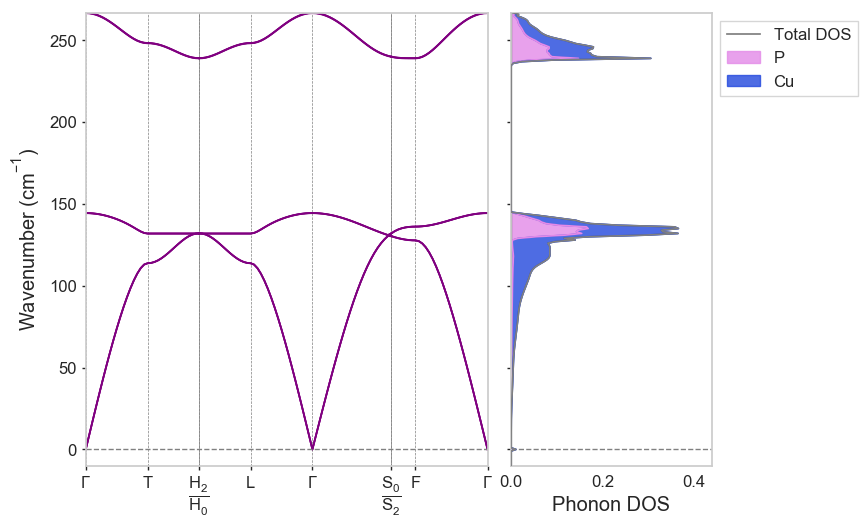

In [15]:
from matador.plotting import plot_spectral
ax = plot_spectral(
    '/u/fs1/afh41/Cu2P-phonon-correct-path/CuP-Ir2P-OQMD_30622-CollCode640898', 
    phonons=True,
    band_colour='purple', 
  #  png=True
)

Using config from /u/fs1/afh41/.matadorrc
Displaying plot...


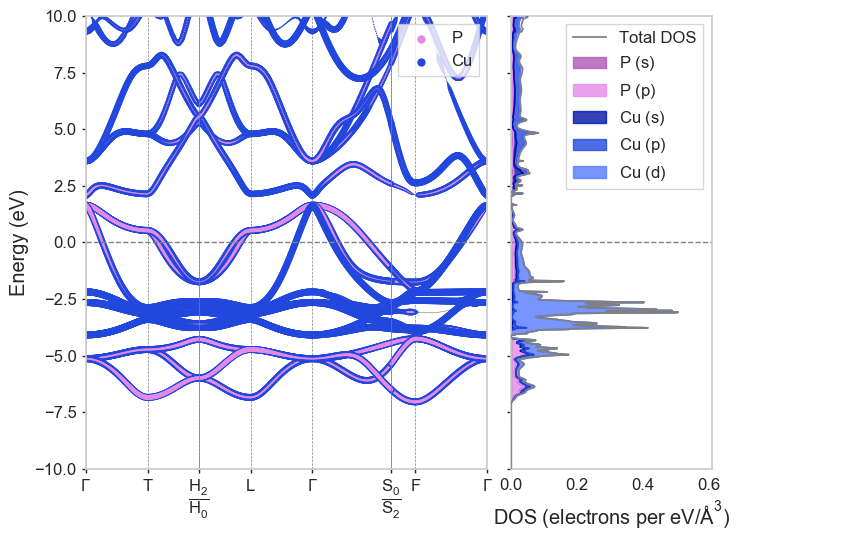

In [16]:
# write now displaying as svg is too taxing when there are many thousand points, so switch to png here 
# long-term solution is probably to rewrite pdis plotting to use variable line widths with variable zorder...
set_matplotlib_formats('png')
plot_spectral(
    '/u/fs1/afh41/Cu2P-bands-elec/CuP-Ir2P-OQMD_30622-CollCode640898',
    pdis_interpolation_factor=5,
  #  png=True
)
set_matplotlib_formats('png')

### Finite temperature stability

100%|██████████| 21/21 [00:00<00:00, 1148.76it/s]

5 structures found within 0.0 eV of the hull, including chemical potentials.
───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
                 Source                  !?!  Pressure  Volume/fu  Hull dist.   Space group     Formula      # fu   Prov.  
                                               (GPa)     (Ang^3)   (meV/atom)  
───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
* Cu-OQMD_592441-CollCode43493                    0.01       11.9          0.0    Fm-3m          Cu          1      ICSD  
* Cu2P-swap-PRh2-OQMD_7002-CollC[..]             -0.00       41.6          0.0   I4/mmm         Cu2P         1     SWAPS  
* CuP2-OQMD_6538-CollCode35282_0                 -0.00      391.9          0.0                  CuP2         4      ICSD  
* Cu2P7-OQMD_6537-CollCode35281_0                 0.05     1306.2          0.0                  Cu2P7 

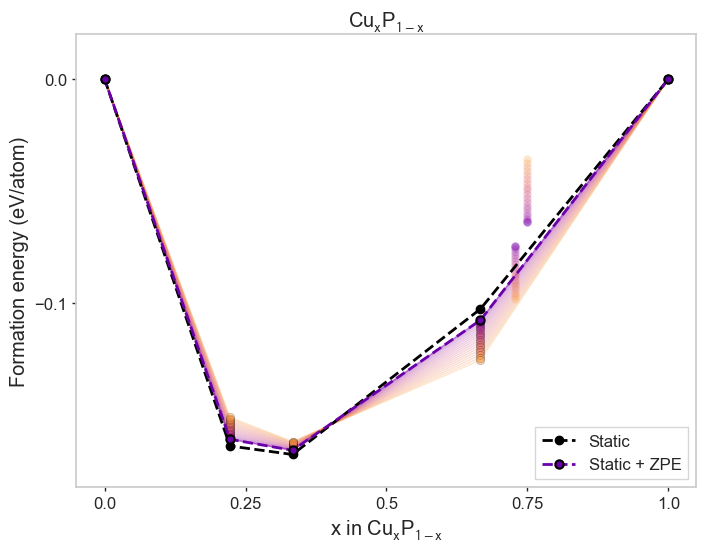

In [17]:
from matador.hull.hull_temperature import TemperatureDependentHull 
cursor, failures = castep2dict('/u/fs1/afh41/Cu3P-phonons/run3/completed/*.castep',db=False)
if failures:
    print(failures)
    
temperatures = np.linspace(0, 600, 21)
# me388 todo: add color bar to these plots
td_hull = TemperatureDependentHull(
    temperatures=temperatures,
    cursor=cursor,
    energy_key='total_energy_per_atom',
    species=['Cu','P']
)
ax = td_hull.plot_hull(plot_points=True)
lims = ax.get_ylim()
ax.set_ylim(lims[0], 0.02);

In [18]:
# plot temperature vs. enthalpy for P and P_SCAN
from matador.orm.spectral import VibrationalDOS
P = VibrationalDOS(castep2dict('/u/fs1/afh41/P-phonon/P-CollCode150873_prim-out_prim.castep', db=False)[0])
P_SCAN = VibrationalDOS(castep2dict('/u/fs1/afh41/P-phonon/SCAN/P-CollCode150873_prim-out_prim.castep', db=False)[0])

Using config from /u/fs1/afh41/.matadorrc
Using config from /u/fs1/afh41/.matadorrc


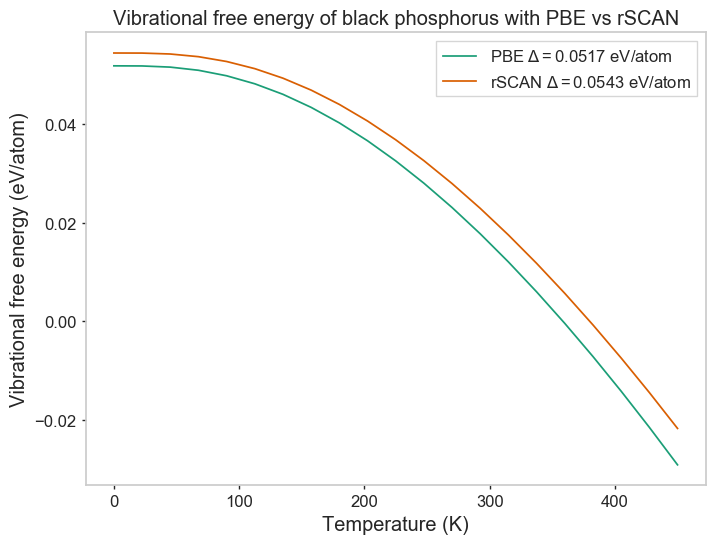

In [19]:
import numpy as np
temperatures = np.linspace(0, 450, 21)
fig, ax = plt.subplots()
ax.set_title('Vibrational free energy of black phosphorus with PBE vs rSCAN')
P.plot_free_energy(temperatures=temperatures, ax=ax, line_kwargs={'label': f'PBE $\\Delta={P.zpe:.4f}$ eV/atom'})
P_SCAN.plot_free_energy(temperatures=temperatures, ax=ax, line_kwargs={'label': f'rSCAN $\\Delta={P_SCAN.zpe:.4f}$ eV/atom'})
ax.legend()

dict_keys(['source', 'user', 'lattice_cart', 'lattice_abc', 'cell_volume', 'atom_types', 'positions_frac', 'num_atoms', 'stoichiometry', 'num_fu', 'external_pressure', 'cell_constraints', 'space_group', 'num_kpoints', 'kpoints_mp_grid', 'species_pot', 'elec_energy_tol', 'nbands', 'nelectrons', 'finite_basis_corr', 'cut_off_energy', 'xc_functional', 'task', 'geom_force_tol', 'spin_polarized', 'phonon_fine_kpoint_list', 'phonon_fine_kpoint_weights', 'eigs_q', 'num_modes', 'kpoint_path', 'kpoint_weights', 'num_qpoints', 'geom_iter', 'total_time_secs', 'total_time_hrs', 'castep_version', '_compiler_architecture', '_castep_commit', 'date', 'num_mpi_processes', 'estimated_mem_per_process_MB', 'estimated_mem_MB', 'peak_mem_MB', 'total_energy', 'total_energy_per_atom', 'smeared_free_energy', 'smeared_free_energy_per_atom', '0K_energy', '0K_energy_per_atom', 'forces', 'max_force_on_atom', 'stress', 'pressure', 'enthalpy', 'enthalpy_per_atom', 'bulk_modulus', 'mulliken_charges', 'mulliken_spins'

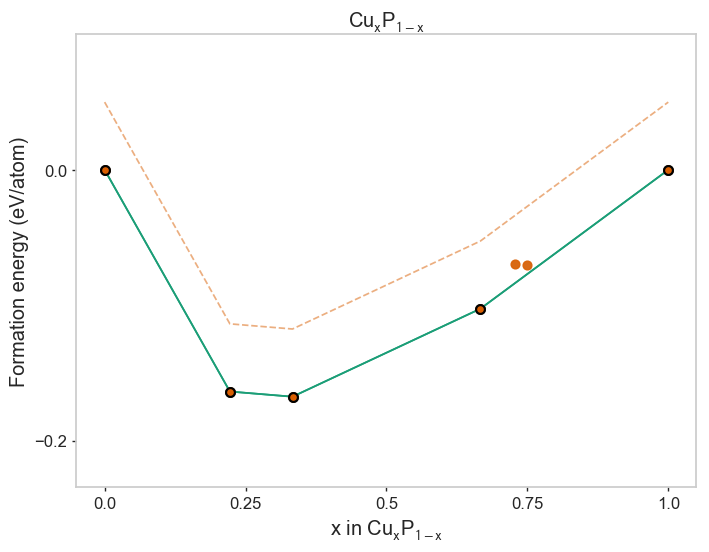

In [20]:
import numpy as np
from scipy.constants import physical_constants
cursor, failures = castep2dict('/u/fs1/afh41/Cu3P-phonons/run3/completed/*.castep',db=False)

k = physical_constants['Boltzmann constant in eV/K'][0]
S = k * np.log(3) # Configurational Entropy S = kln(w)
T = 0

for ind, doc in enumerate(cursor):
    dos = VibrationalDOS(doc)
    if doc['stoichiometry'] == [['Cu', 8.0], ['P', 3.0]]:
        entropy_contrib = S*T
        print(doc.keys())
        print(doc['0K_energy'])
        print(doc['smeared_free_energy'])
        print(doc['total_energy'])
    else:
        entropy_contrib = 0
 #   doc['300_free_energy'] = doc['smeared_free_energy'] + dos.vibrational_free_energy(T) - entropy_contrib
 #    doc['300_free_energy'] = doc['0K_energy'] + dos.vibrational_free_energy(T) - entropy_contrib
    doc['300_free_energy'] = doc['total_energy']
    doc['300_free_energy_per_atom'] = doc['300_free_energy'] / doc['num_atoms']
    
config_entropy_polished_hull = QueryConvexHull(
    cursor=cursor,
    energy_key='300_free_energy',
    species=['Cu','P'],
    hull_cutoff=0.05
)


### Structural similarity between Cu$_2$P, Cu$_3$P$_{11}$ and Cu$_3$P

In [21]:
# Assess the pdf similarity of Cu3P11 and Cu2P/Cu2P7
from matador.crystal import Crystal
from matador.plotting import plot_pdf, plot_projected_pdf
cursor, failures = res2dict('/u/fs1/afh41/query-Cu3P11-afh41-LiCuP-polish/*.res', as_model=True)
cursor = [Crystal(doc) for doc in cursor]
plot_pdf(cursor[-1].pdf, other_pdfs=[doc.pdf for doc in cursor[:-1]])

Nothing to scrape.


TypeError: 'NoneType' object is not iterable

### Similarity of Cu3P phases

In [ ]:
Cu3P_cursor = sorted([Crystal(doc) for doc in polished_hull.cursor], key=lambda doc: doc["formation_enthalpy_per_atom"])
Cu3P_cursor = [doc for doc in Cu3P_cursor if (doc.formula == 'Cu3P' and doc['hull_distance'] < 80)]
display_results(Cu3P_cursor, use_source=True)

In [ ]:
from matador.utils.cell_utils import get_space_group_label_latex
plot_pdf(Cu3P_cursor[0].pdf, other_pdfs=[doc.pdf for doc in Cu3P_cursor[1:]], 
         labels=[get_space_group_label_latex(doc.space_group).replace("\\text", "") for doc in Cu3P_cursor])

### Plot BZ with kpoint path (needs some work...)

Need to grab this directly from Seekpath, I think to ensure everything is standardized.

In [ ]:
import matplotlib.pyplot
from mpl_toolkits.mplot3d import Axes3D
from matador.orm.spectral import VibrationalDispersion
from matador.scrapers import phonon2dict
from matador.utils.cell_utils import real2recip, frac2cart
%matplotlib notebook
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
doc = Cu3P_cursor[0]
phonons = phonon2dict('/u/fs1/afh41/Cu2P-phonon-correct-path/CuP-Ir2P-OQMD_30622-CollCode640898.phonon', as_model=True)[0]
vectors = real2recip(phonons.lattice_cart)
kpoint_path = np.asarray(frac2cart(real2recip(phonons.lattice_cart), phonons.kpoint_path)).T
for ind, vec in enumerate(vectors):
    #  singlets
    ax.plot(*[[0, vec[i]] for i in range(3)], c='k', lw=2, zorder=1000)
    #  doublets
    ax.plot(*[[vectors[ind-1][i] + vec[i], vec[i]] for i in range(3)], c='k')
    ax.plot(*[[vectors[ind-2][i] + vec[i], vec[i]] for i in range(3)], c='k')
    # triplets
    ax.plot(*[[vectors[ind-1][i] + vectors[ind-2][i] + vec[i], vectors[ind-1][i] + vec[i]] for i in range(3)], c='k')
    
ax.plot(*kpoint_path, c='red', ls='--')